In [1]:
import sys
sys.path.append('../')
import QPGWR
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

## Field Data illustration

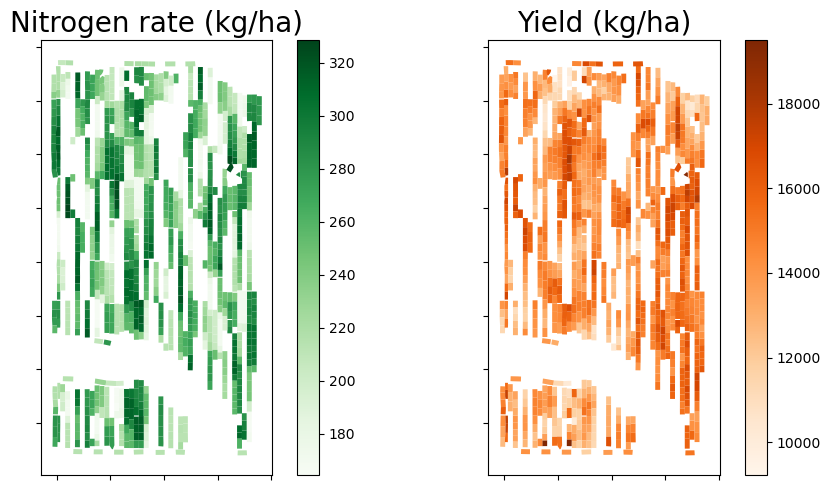

In [2]:
#select field
field_num=20

field_data=gpd.read_file('../DIFM/data/FieldData/DIFM Corn/DIFM Corn/'+str(field_num)+'/analysis_data.shp')

field_data['n_rate']=field_data['n_rate']*1.12
field_data['yild_vl']=field_data['yild_vl']*67.251

field_data['N2']=field_data['n_rate']**2

locations=field_data.geometry.centroid
field_data['X']=locations.x
field_data['Y']=locations.y

fig, axes = plt.subplots(1,2,figsize=(10,5))
field_data.plot('n_rate',ax=axes[0],cmap='Greens',legend=True,markersize=10)
field_data.plot('yild_vl',ax=axes[1],cmap='Oranges',legend=True,markersize=10)
axes[0].set_title('Nitrogen rate (kg/ha)',fontsize=20)
axes[1].set_title('Yield (kg/ha)',fontsize=20)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])

#tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.tight_layout()

## GWR Fitting

### QP and LP-GWR

In [3]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

data=field_data.copy()
xy=np.array(data[['X','Y']])

######################################################################
# for LP-GWR
# initial values
popt0=[data['yild_vl'].min(),(data['yild_vl'].max()-data['yild_vl'].min())/(data['n_rate'].max()-data['n_rate'].min()),data['n_rate'].mean()]
data_LP=QPGWR.LPGWR(data,50,xy,popt0)

data_gpd=gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.X, data.Y))

# calculate ENOR for LP-GWR
data_gpd['Nk_lp']=data_LP['NK_']
EONR_lp=data_gpd['Nk_lp']

######################################################################
# for QP-GWR
# initial values
popt0=[data['n_rate'].mean(),-(data['yild_vl'].max()-data['yild_vl'].min())/(data['n_rate'].mean()-data['n_rate'].min())**2,data['yild_vl'].max()]
data_QP=QPGWR.QPGWR(data,50,xy,popt0)

data_gpd['a_qp']=data_QP['a_']
data_gpd['x0_qp']=data_QP['x0_']
data_gpd['y0_qp']=data_QP['y0_']

# calculate EONR for QP-GWR
pr = 6.56/(2.2*25.4)
b1_ = -2*data_gpd['a_qp']*data_gpd['x0_qp']
b2_ = data_gpd['a_qp']
EONR_qp = (pr-b1_)/2/b2_

# boundary condition
def boundary_condition(EONR,vmin,vmax):
    EONR[EONR>vmax]=vmax
    EONR[EONR<vmin]=vmin
    return EONR

vmax=data_gpd['n_rate'].max()
vmin=data_gpd['n_rate'].min()

EONR_lp=boundary_condition(EONR_lp,vmin,vmax)
EONR_qp=boundary_condition(EONR_qp,vmin,vmax)

/var/folders/2w/068y3jnn3hv7439tk2y0tfmh0000gn/T/ipykernel_30278/4238130077.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EONR[EONR>vmax]=vmax
/var/folders/2w/068y3jnn3hv7439tk2y0tfmh0000gn/T/ipykernel_30278/4238130077.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EONR[EONR<vmin]=vmin


### Q_GWR

In [4]:
# !pip install mgwr

In [5]:
#MGWR functions
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

y = data['yild_vl'].values
X = data[['n_rate','N2']].values
u = data['X']
v = data['Y']
coords = list(zip(u,v))
y = y.reshape(-1,1)

gwr_results = GWR(coords, y, X, bw=50, kernel='gaussian').fit()

data_gpd['b1_q']=gwr_results.params[:,1]
data_gpd['b2_q']=gwr_results.params[:,2]
EONR_q=(pr-data_gpd['b1_q'])/2/data_gpd['b2_q']
EONR_q=boundary_condition(EONR_q,vmin,vmax)


[Text(0, 4511700.0, ''),
 Text(0, 4511800.0, ''),
 Text(0, 4511900.0, ''),
 Text(0, 4512000.0, ''),
 Text(0, 4512100.0, ''),
 Text(0, 4512200.0, ''),
 Text(0, 4512300.0, ''),
 Text(0, 4512400.0, ''),
 Text(0, 4512500.0, ''),
 Text(0, 4512600.0, '')]

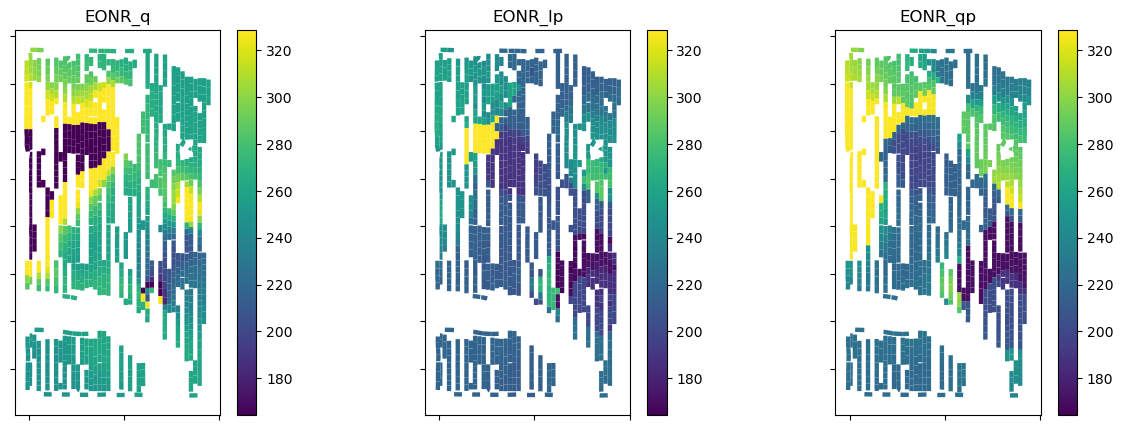

In [6]:
# plot the EONR_q, EONR_lp and EONR_qp in 3 subplots
fig, axes = plt.subplots(1,3,figsize=(15,5))
field_data.plot(EONR_q,ax=axes[0],legend=True,markersize=10,vmax=vmax,vmin=vmin)
field_data.plot(EONR_lp,ax=axes[1],legend=True,markersize=10,vmax=vmax,vmin=vmin)
field_data.plot(EONR_qp,ax=axes[2],legend=True,markersize=10,vmax=vmax,vmin=vmin)
#set the title
axes[0].set_title('EONR_q')
axes[1].set_title('EONR_lp')
axes[2].set_title('EONR_qp')

#revmove the axis
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
axes[2].set_xticklabels([])
axes[2].set_yticklabels([])


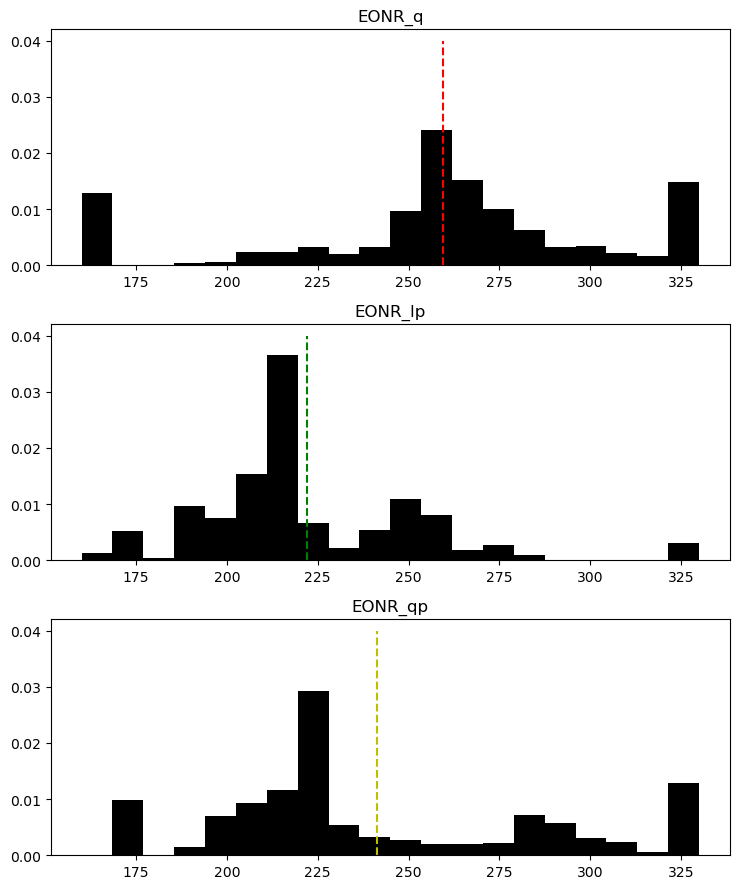

In [7]:
Q=EONR_q.mean()#214.8306118044037
lp=EONR_lp.mean()#197.68091149209562
qp=EONR_qp.mean()#207.29026084147367


#subplot for the EONR
fig,axes=plt.subplots(3,1,figsize=(5*1.5,2*1.5*3))
axes[0].hist(EONR_q,histtype='bar',color='black',range=(160,330),bins=20,density=True)#4.04685642
axes[0].title.set_text('EONR_q')
axes[0].plot([Q,Q],[0,0.04],'r--')
axes[1].hist(EONR_lp,histtype='bar',color='black',range=(160,330),bins=20,density=True)#4.04685642
axes[1].title.set_text('EONR_lp')
axes[1].plot([lp,lp],[0,0.04],'g--')
axes[2].hist(EONR_qp,histtype='bar',color='black',range=(160,330),bins=20,density=True)#4.04685642
axes[2].title.set_text('EONR_qp')
axes[2].plot([qp,qp],[0,0.04],'y--')
plt.tight_layout()
